In [1]:
# %pip install -qU experiment-results-manager \
#     scikit-learn \
#     pandas

import sys, os
sys.path.insert(0, f"{os.getenv('HOME')}/code/experiment-results-manager")

In [2]:
import pandas as pd
import experiment_results_manager as erm
import pickle

from experiment_results_manager.artifact import ArtifactType
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_iris
from IPython.display import display, HTML

In [3]:
iris = load_iris()
feature_names = iris.feature_names
iris_df = pd.DataFrame(iris.data, columns=feature_names)
iris_df['target'] = iris.target
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [19]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    iris_df.drop('target', axis=1), 
    iris_df['target'],
)

# Let's try some different classifiers
rf = RandomForestClassifier(random_state=666)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

gbt = GradientBoostingClassifier(random_state=666)
gbt.fit(X_train, y_train)
gbt_pred = gbt.predict(X_test)

dt = DecisionTreeClassifier(max_depth = 3, random_state = 1)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [28]:
pd.DataFrame({
    "y_true": y_test,
    "dt_pred": dt_pred,
    "rf_pred": rf_pred,
    "gbt_pred": gbt_pred
})

,y_true,dt_pred,rf_pred,gbt_pred
70,1,2,2,2
16,0,0,0,0
99,1,1,1,1
1,0,0,0,0
101,2,2,2,2
130,2,2,2,2
85,1,1,1,1
120,2,2,2,2
114,2,2,2,2
62,1,1,1,1


In [26]:
from matplotlib import pyplot as plt
from numpy import mean
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_and_log_run(model, y_test, y_pred, variant_id):
    er = erm.ExperimentRun(
        experiment_id="iris",
        variant_id=variant_id,
        params={
            "model": type(model).__name__
        },
        features=feature_names,
        metrics={
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average='weighted'),
            "recall": recall_score(y_test, y_pred, average='weighted'),
            "f1": f1_score(y_test, y_pred, average='weighted')
        }
    )

    er.log_dict("custom_dict", data={
        "avg_pred_value": mean(y_pred)
    })

    er.log_artifact(
        pickle.dumps(model), 
        artifact_id="model", 
        filename="model.pickle", 
        artifact_type=ArtifactType.BINARY)
    
    plt.clf()
    fig = sns.heatmap(
        confusion_matrix(y_test, dt_pred), 
        annot=True, 
        cmap="Blues"
    )
    fig.set_xlabel('Predicted')
    fig.set_ylabel('Actual')
    fig.set_title(variant_id)
    er.log_figure(fig, "confusion_matrix")
    
    return er

er_rf = evaluate_and_log_run(rf, y_test, rf_pred, "random_forest")
er_gbt = evaluate_and_log_run(gbt, y_test, gbt_pred, "gradient_boosting")
er_dt = evaluate_and_log_run(dt, y_test, dt_pred, "decision_tree")
plt.clf()

<Figure size 640x480 with 0 Axes>


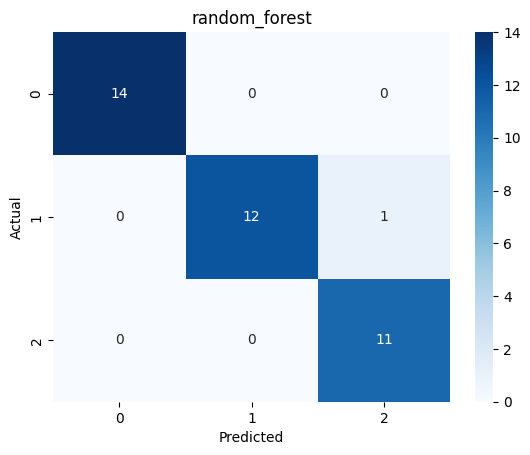
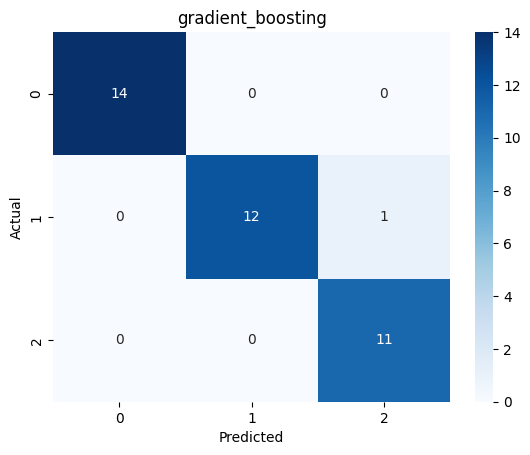
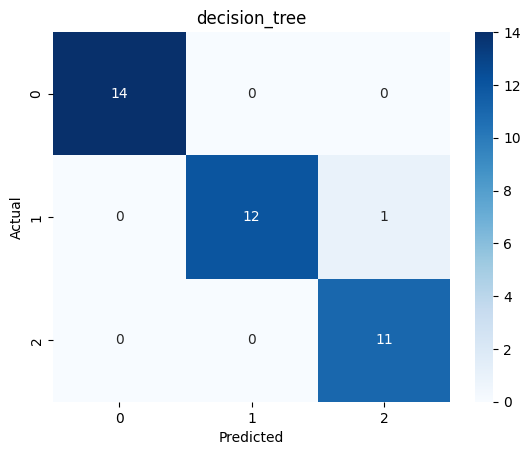

In [21]:
display(HTML(erm.compare_runs(er_rf, er_gbt, er_dt)))